<a href="https://colab.research.google.com/github/Navya-prasad/YOLOv8n-based-Driver-Monitoring-System/blob/main/Copy_of_Skin_cancer_AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# needed to import dataset from google drive into colab
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
cd gdrive

/content/gdrive


In [ ]:
cd MyDrive

/content/gdrive/MyDrive


In [ ]:
# Import the required dependencies
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
# Set all the constants
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS = 3
EPOCHS = 100

In [ ]:
# Import data into TensorFlow Dataset object
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/MyDrive/Colab Notebooks/cancer-full-dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 1968 files belonging to 2 classes.


In [ ]:
class_names = dataset.class_names
class_names

['benign', 'malignant']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]


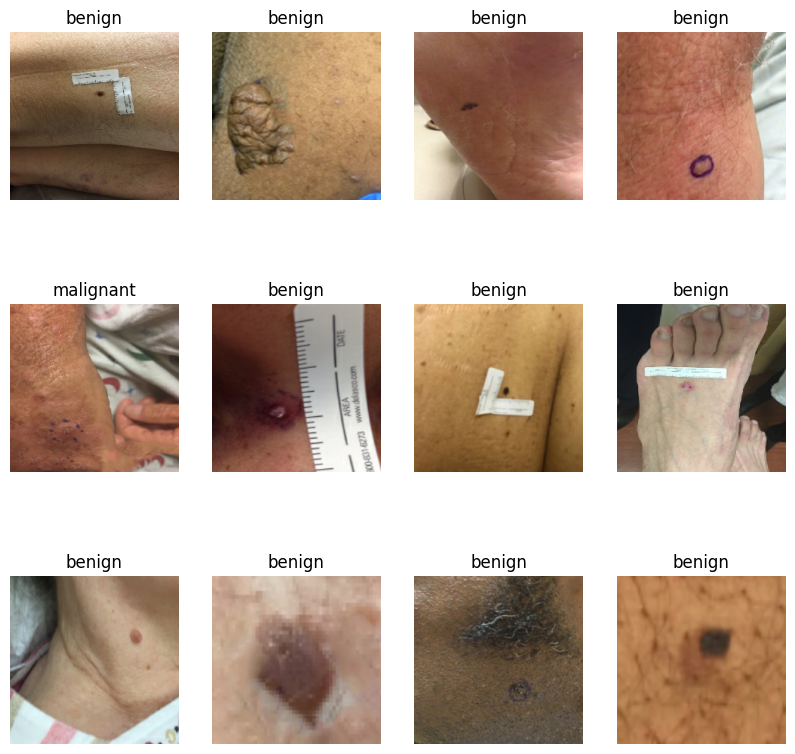

In [ ]:
# Visualize some of the images from our dataset
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
# Function to Split Dataset
len(dataset)

62

In [ ]:
train_size = 0.8
len(dataset) * train_size

49.6

In [ ]:
train_ds = dataset.take(54)
len(train_ds)

54

In [ ]:
test_ds = dataset.skip(54)
len(test_ds)

8

In [ ]:
val_size = 0.1
len(dataset) * val_size

6.2

In [ ]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [ ]:
test_ds = test_ds.skip(6)
len(test_ds)

2

In [ ]:
# Function to split the dataset
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

49

In [ ]:
len(val_ds)

6

In [ ]:
len(test_ds)

7

In [ ]:
# Cache, shuffle, and prefetch the dataset
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Building the Model
# Creating a new Layer for Resizing and Normalization
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./244),
])

In [ ]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
# Applying Data Augmentation to Train Dataset
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Building the AlexNet model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    layers.experimental.preprocessing.Rescaling(1./244, input_shape=input_shape),
    layers.Conv2D(96, kernel_size=(11, 11), strides=(4, 4), activation='relu'),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    layers.Conv2D(256, kernel_size=(5, 5), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    layers.Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'),
    layers.Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'),
    layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dense(4096, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2  (None, 26, 26, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 384)      

In [ ]:
# Compiling the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
# Training the model
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/100
49/49 [==============================] - 217s 651ms/step - loss: 1.3923 - accuracy: 0.7294 - val_loss: 0.5779 - val_accuracy: 0.7386
Epoch 2/100
49/49 [==============================] - 11s 214ms/step - loss: 0.5656 - accuracy: 0.7539 - val_loss: 0.5773 - val_accuracy: 0.7386
Epoch 3/100
49/49 [==============================] - 10s 196ms/step - loss: 0.5600 - accuracy: 0.7539 - val_loss: 0.5746 - val_accuracy: 0.7386
Epoch 4/100
49/49 [==============================] - 11s 230ms/step - loss: 0.5622 - accuracy: 0.7539 - val_loss: 0.5746 - val_accuracy: 0.7386
Epoch 5/100
49/49 [==============================] - 11s 222ms/step - loss: 0.5602 - accuracy: 0.7539 - val_loss: 0.5807 - val_accuracy: 0.7386
Epoch 6/100
49/49 [==============================] - 10s 211ms/step - loss: 0.5586 - accuracy: 0.7539 - val_loss: 0.5807 - val_accuracy: 0.7386
Epoch 7/100
49/49 [==============================] - 10s 209ms/step - loss: 0.5613 - accuracy: 0.7539 - val_loss: 0.5753 - val_accuracy

In [ ]:
scores = model.evaluate(test_ds)

7/7 [==============================] - 20s 23ms/step - loss: 0.5878 - accuracy: 0.7277


In [ ]:
scores
#Score is just a list containing loss and accuracy value

[0.5877914428710938, 0.7276785969734192]

In [ ]:
#Plotting the Accuracy and Loss Curves
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 49}

In [ ]:
history.history.keys()
#loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
type(history.history['loss'])

list

In [ ]:
len(history.history['loss'])

100

In [ ]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.3922955989837646,
 0.5655686259269714,
 0.5599586367607117,
 0.5622146129608154,
 0.5601592659950256]

In [ ]:
# Plotting the Accuracy and Loss Curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


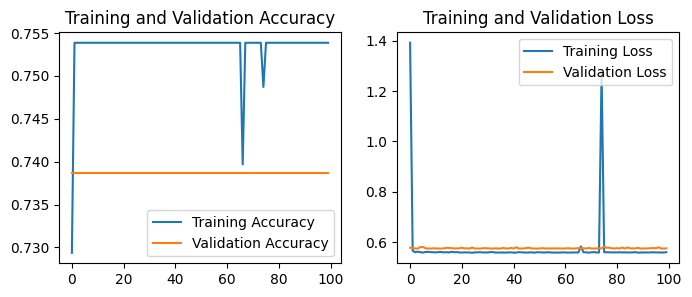

In [ ]:
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
import itertools

1/1 [==============================] - 0s 32ms/step
True Positives (TP): 0
False Positives (FP): 61
True Negatives (TN): 163
False Negatives (FN): 0
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


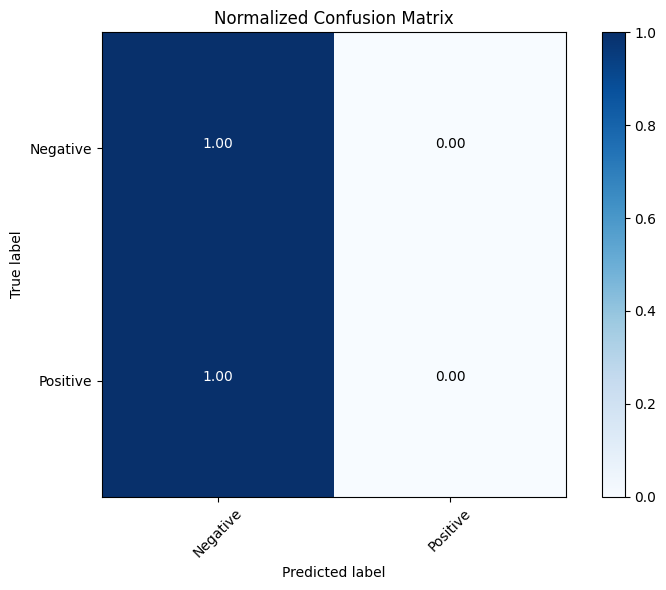

Precision: [0.72767857 0.        ]
Recall: [1. 0.]
F1-Score: [0.84237726 0.        ]


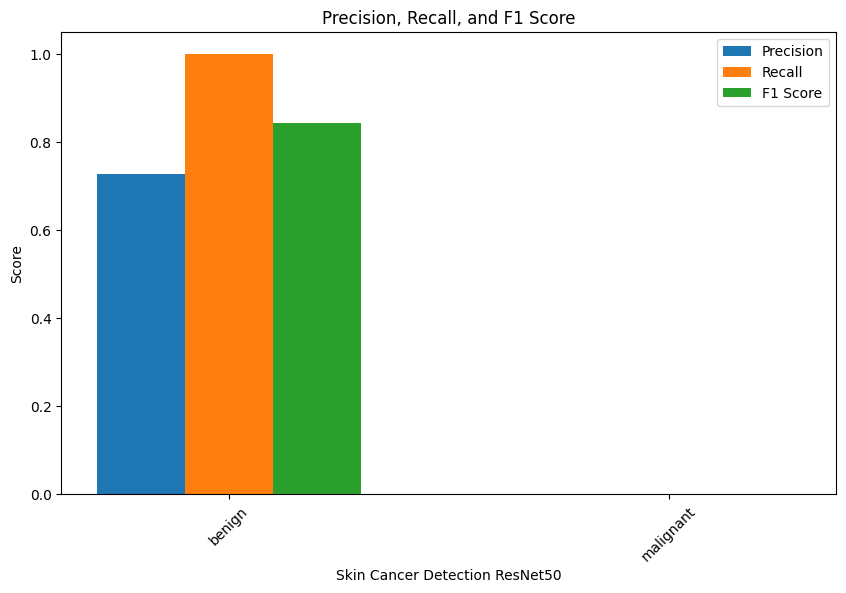

In [ ]:
import itertools
# Printing Precision, Recall, and F1 Score
test_images = []
test_labels = []
predicted_labels = []

for images_batch, labels_batch in test_ds:
    test_images.extend(images_batch.numpy())
    test_labels.extend(labels_batch.numpy())
    batch_prediction = model.predict(images_batch)
    predicted_labels.extend(np.argmax(batch_prediction, axis=1))

test_labels = np.array(test_labels)
predicted_labels = np.array(predicted_labels)

precision = precision_score(test_labels, predicted_labels, average=None, zero_division=0)
recall = recall_score(test_labels, predicted_labels, average=None)
f1 = f1_score(test_labels, predicted_labels, average=None)

from sklearn.metrics import confusion_matrix

# Assuming you have your test labels (`test_labels`) and predicted labels (`predicted_labels`) as NumPy arrays

# Calculate the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)
TP = cm[1, 1]  # True Positives
FP = cm[1, 0]  # False Positives
TN = cm[0, 0]  # True Negatives
FN = cm[0, 1]  # False Negatives

print("True Positives (TP):", TP)
print("False Positives (FP):", FP)
print("True Negatives (TN):", TN)
print("False Negatives (FN):", FN)

# Optional: Plot the confusion matrix
def plot_confusion_matrix(cm, class_names=None, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    Plots a confusion matrix with labels and normalization options.

    Args:
        cm (numpy.ndarray): Confusion matrix.
        class_names (list, optional): List of class names (default: None).
        normalize (bool, optional): Normalize confusion matrix (default: False).
        title (str, optional): Title for the confusion matrix plot (default: None).
        cmap (matplotlib.colors.Colormap, optional): Colormap for the plot (default: plt.cm.Blues).

    Returns:
        None
    """

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix")

    print(cm)

    plt.figure(figsize=(8, 6))  # Adjust figure size as needed

    if class_names is not None:
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=45)
        plt.yticks(tick_marks, class_names)

    # Display heatmap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()

    # Text labels for each cell
    if normalize:
        fmt = '.2f'
    else:
        fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    if title is not None:
        plt.title(title)

    plt.tight_layout()
    plt.show()  # Customize as needed
plot_confusion_matrix(cm, class_names=["Negative", "Positive"], normalize=True, title="Normalized Confusion Matrix")
# Calculate Precision, Recall, and F1 Score
precision = precision_score(test_labels, predicted_labels, average=None, zero_division=0)
recall = recall_score(test_labels, predicted_labels, average=None)
f1 = f1_score(test_labels, predicted_labels, average=None)
# Print precision, recall, and F1-score
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
# Plotting the metrics
plt.figure(figsize=(10, 6))
x = np.arange(len(class_names))

plt.bar(x - 0.2, precision, width=0.2, label='Precision')
plt.bar(x, recall, width=0.2, label='Recall')
plt.bar(x + 0.2, f1, width=0.2, label='F1 Score')

plt.xticks(x, class_names, rotation=45)
plt.xlabel('Skin Cancer Detection ResNet50')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score')
plt.legend()
plt.show()

In [ ]:
test_labels = np.array(test_labels)
predicted_labels = np.array(predicted_labels)

# Calculate the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[163   0]
 [ 61   0]]


1/1 [==============================] - 0s 35ms/step


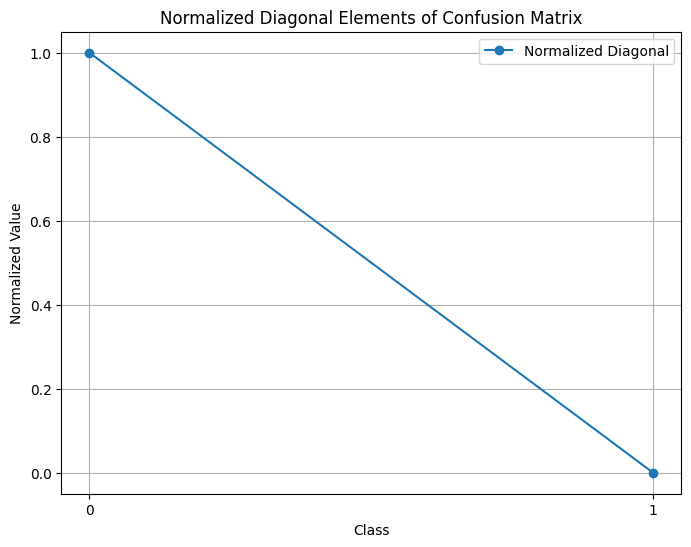

In [ ]:
import itertools  # Import for product function in plot_confusion_matrix

def plot_confusion_matrix(cm, class_names=None, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    Plots a confusion matrix with labels and normalization options.

    Args:
        cm (numpy.ndarray): Confusion matrix.
        class_names (list, optional): List of class names (default: None).
        normalize (bool, optional): Normalize confusion matrix (default: False).
        title (str, optional): Title for the confusion matrix plot (default: None).
        cmap (matplotlib.colors.Colormap, optional): Colormap for the plot (default: plt.cm.Blues).

    Returns:
        None
    """

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix")

    print(cm)

    plt.figure(figsize=(8, 6))  # Adjust figure size as needed

    if class_names is not None:
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=45)
        plt.yticks(tick_marks, class_names)

    # Display heatmap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()

    # Text labels for each cell
    if normalize:
        fmt = '.2f'
    else:
        fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    if title is not None:
        plt.title(title)

    plt.tight_layout()
    plt.show()

# ... (rest of your code for loading your model and test data)

test_images = []
test_labels = []
predicted_labels = []

for images_batch, labels_batch in test_ds:
    test_images.extend(images_batch.numpy())
    test_labels.extend(labels_batch.numpy())
    batch_prediction = model.predict(images_batch)
    predicted_labels.extend(np.argmax(batch_prediction, axis=1))

test_labels = np.array(test_labels)
predicted_labels = np.array(predicted_labels)

# Calculate Confusion Matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Extract diagonal elements (True Positives, True Negatives) for normalized matrix
diagonal_elements = cm.diagonal() / cm.sum(axis=1)

# Plotting the diagonal elements (consider separate line for each class if applicable)
plt.figure(figsize=(8, 6))
x = np.arange(len(diagonal_elements))  # Assuming same number of classes for true labels and predicted labels
plt.plot(x, diagonal_elements, marker='o', label='Normalized Diagonal')
plt.xticks(x)  # Set custom class names if needed (optional)
plt.xlabel('Class')
plt.ylabel('Normalized Value')
plt.title('Normalized Diagonal Elements of Confusion Matrix')
plt.legend()
plt.grid(True)
plt.show()

# ... (rest of your code for calculating and plotting precision, recall, F1 score)


1/1 [==============================] - 0s 26ms/step


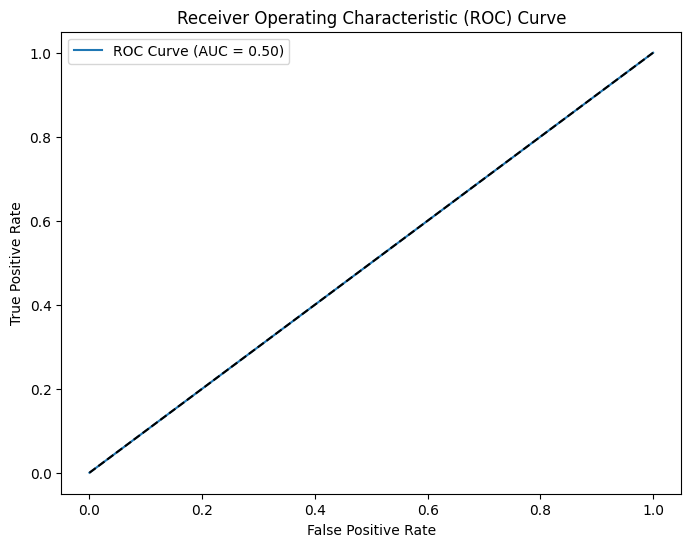

AUC Score: 0.5


In [ ]:
# After evaluating the model on the test set
test_images = []
test_labels = []
predicted_probabilities = []

for images_batch, labels_batch in test_ds:
    test_images.extend(images_batch.numpy())
    test_labels.extend(labels_batch.numpy())
    batch_prediction = model.predict(images_batch)
    predicted_probabilities.extend(batch_prediction)

test_labels = np.array(test_labels)
predicted_probabilities = np.array(predicted_probabilities)

# Calculate the ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(test_labels, predicted_probabilities[:, 1])
auc_score = roc_auc_score(test_labels, predicted_probabilities[:, 1])

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Print the AUC score
print('AUC Score:', auc_score)







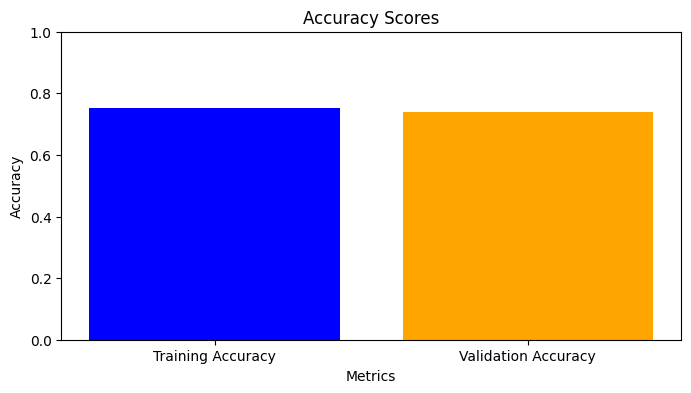

In [ ]:
# Plotting the Accuracy Scores
plt.figure(figsize=(8, 4))
metrics = ["Training Accuracy", "Validation Accuracy"]
accuracy_scores = [acc[-1], val_acc[-1]]

plt.bar(metrics, accuracy_scores, color=['blue', 'orange'])
plt.ylim(0, 1)  # Set the y-axis limit from 0 to 1
plt.xlabel("Metrics")
plt.ylabel("Accuracy")
plt.title("Accuracy Scores")
plt.show()


first image to predict
actual label: benign
1/1 [==============================] - 0s 27ms/step
predicted label: benign


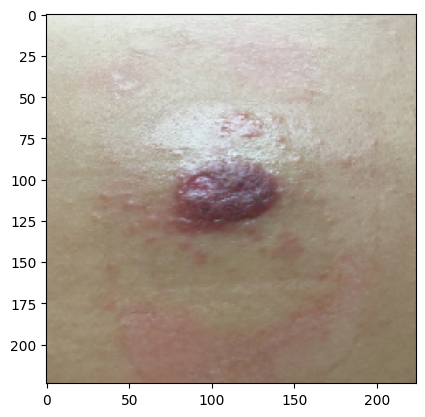

In [ ]:
#Run prediction on a sample image
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
#Write a function for inference
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 18ms/step


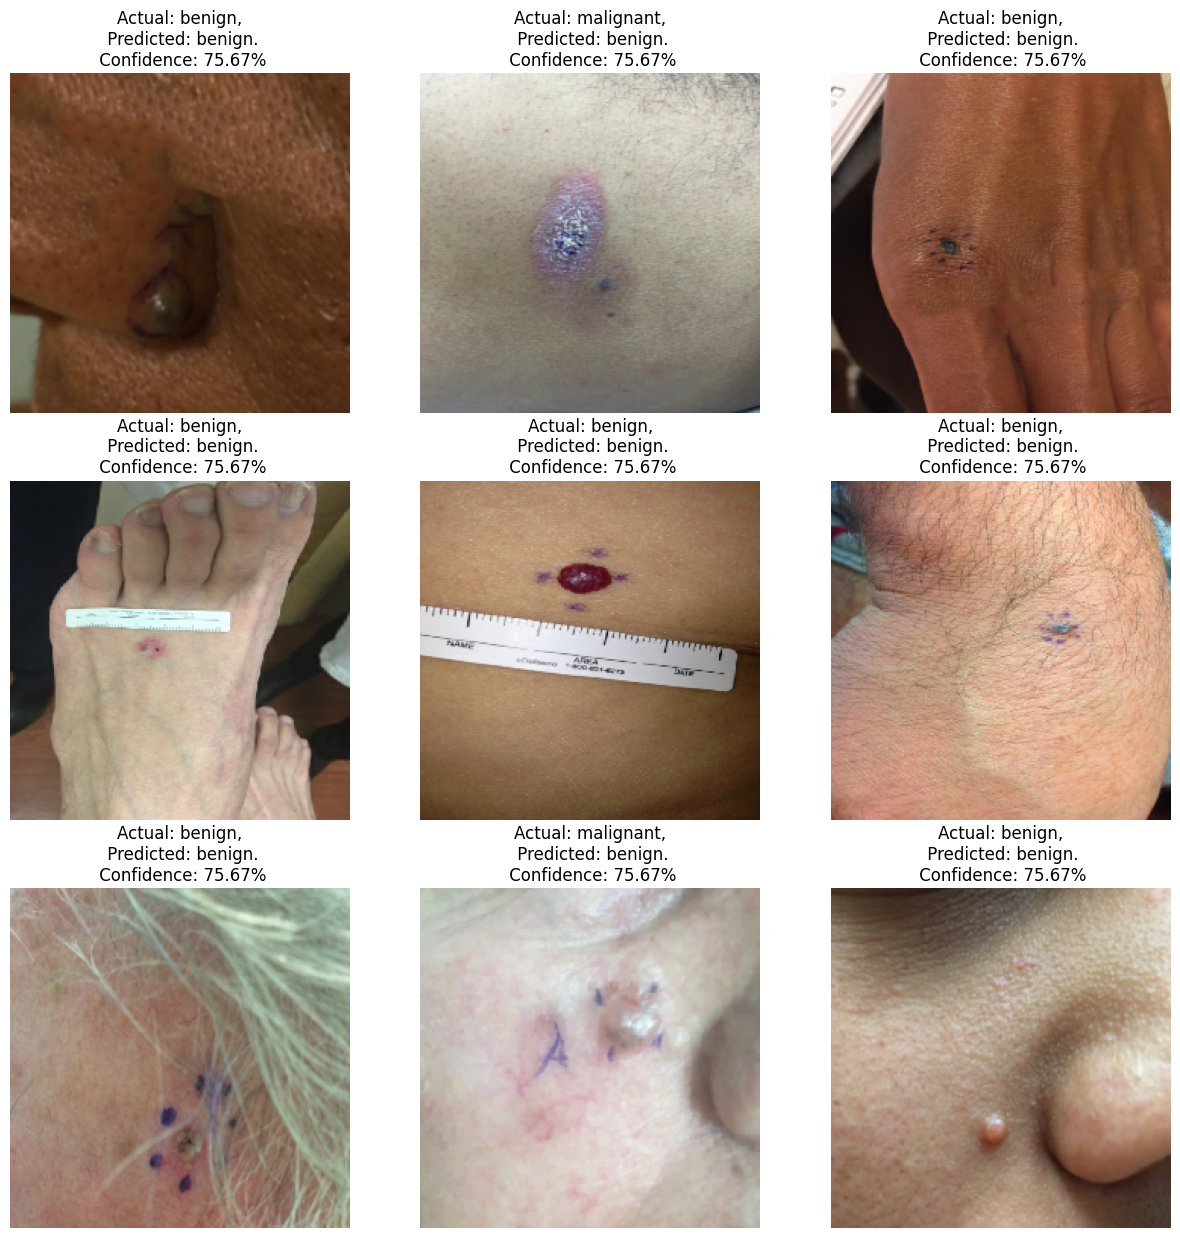

In [ ]:
#Now run inference on few sample images
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
# Saving the model
model.save("skinalexnet.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
